In [5]:

from bitarray import bitarray
from PAMI.subgraphMining.basic import gspan as gsp
from PAMI.extras.stats import graphDatabase as gdb
from PAMI.GraphTransactionalCoveragePattern.basic import abstract as _ab


In [6]:
class GTCP:
    def __init__(self,iFile,minsup,minGTC,minGTPC,maxOR=0.2):
        """
            iFile : input file
            minsup : Minimum support 
            minGTC : Minimum Graph transaction coverage
            minGTPC : Minimum graph pattern coverage 
            maxOR : Maximum overlap ratio
            Sf : subgraphsBygraphID
            Df: Flat transactional Dataset
        """

        self.Df=[]
        self.Sf=[]
        self.L={}
        self.iFile=iFile
        self.maxOR=maxOR
        self.minGTC=minGTC 
        self.minGTPC=minGTPC
        gdb_obj=gdb.graphDatabase(self.iFile)
        self.numGraphs=len(gdb_obj.graphs)
        self.minsup=minsup
        # print("Subgraph mining completed")

    def mine(self):
        """
            Mine the coverage patterns
        """
        self._startTime = _ab._time.time()
        gsp_obj = gsp.GSpan(self.iFile, self.minsup, outputSingleVertices=False, maxNumberOfEdges=float('inf'), outputGraphIds=True)
        gsp_obj.mine()
       
        print("Subgraph mining completed")
        self.Sf=gsp_obj.getSubgraphGraphMapping()
        self.GetFIDBasedFlatTransactions()
        s=0
        for i in self.Df:
            s+=self.Df[i].count()
        
        self.avg=s/len(self.Df)
        self.gspant=_ab._time.time() - self._startTime
        self.Cmine()
    

    def getPatterns(self):
        """
            Get all the coverage patterns
        """
        return self.L

    def Coverage(self,g):
        """
            Get coverage of a graph
            param
                g : Graph id
        """
        return self.Df[g].count()/len(self.Sf)


    def patternCoverage(self,pattern):
        """
            Get patternCoverage of a pattern
            param
                pattern: pattern for which pattern coverage needs to be computed
        """
        Csets=list(map(lambda x:self.Df[x] ,pattern))
        newset=bitarray(len(self.Sf))
        for coverage in Csets:
            newset=newset | coverage
        return newset

    def OverlapRatio(self,pattern):
        """
            Get Overlap ratio of a pattern
            param
                pattern: pattern for which overlap ratio needs to be computed
        """

        lastitem=pattern[-1]
        lastbut=pattern[:-1]
        lastbutcoverage=self.patternCoverage(lastbut)
        lastcoverage=self.Df[lastitem]
        
        intersection=lastcoverage & lastbutcoverage
        cs= (lastcoverage | lastbutcoverage).count()/len(self.Sf)
        return (intersection.count()/self.Df[lastitem].count(),cs)


    def GetFIDBasedFlatTransactions(self):
        """
            Convert into FID based transactions
        """
        self.Df={}
        for i in range(self.numGraphs):
            bitset = bitarray(len(self.Sf))
            bitset.setall(0)
            self.Df.update({i:bitset})

        for fragment in self.Sf:
            for GID in fragment["GIDs"]:
                self.Df[GID][fragment["FID"]]=1

    def getallFreq1(self):
        """
            Get all the Patterns of size 1

        """
        freq=[(graph,self.Coverage(graph)) for graph in self.Df if self.Coverage(graph)>=self.minGTC]

        sorted_list = sorted(freq, key=lambda x: x[1], reverse=True)
        final_list=list(map(lambda x: [x[0]],sorted_list))
        return final_list

    def join(self,l1,l2):
        """
            Join two patterns
            Param 
                l1: Pattern 1
                l2: Pattern 2
        """
        patterns=[]
        Nol=[]
        temp_l=[]
        newpattern=[]
        for i in range(len(l1)):
            for j in range(i+1,len(l2)):
                if(l1[i][:-1]==l2[j][:-1]):
                    if(self.Coverage(l1[i][-1])>=self.Coverage(l2[j][-1])):
                        newpattern= l1[i]+[l2[j][-1]]
                    else:
                        newpattern=l2[j]+[l1[i][-1]]
                    
                    ov,cs=self.OverlapRatio(newpattern)
                    
                    if(ov<=self.maxOR):
                        if(cs>=self.minGTPC):
                            self.L.append((newpattern,cs))
                        else:
                            self.Nol.append(newpattern)
                else:
                    break
        # return (Nol,temp_l)    
    

    def writePatterns(self):
        outf=self.iFile.split(".")[0]+"_results.txt"
        f=open(outf,"w+")
        for i in self.L:
            f.write(str(i[0])+", Coverage : "+str(i[1]))
            f.write("\n")
        
        f.close()
    
    def Cmine(self):
        """
        Cmine Algorithm for mining coverage patterns
        """

        self.Nol_1=self.getallFreq1()
        l=1
        self.L=[]
        self.Nol_1_temp=[]
        self.candidate=len(self.Nol_1)
        for g in self.Nol_1:
            if(self.Coverage(g[0])>=self.minGTPC):
                self.L.append((g,self.Coverage(g[0])))
            else:
                self.Nol_1_temp.append(g)
        l+=1
        self.Nol_1=self.Nol_1_temp
        self.Nol=[]


        while(len(self.Nol_1)>0):
            self.Nol=[]
            # print(len(self.Nol_1))
            self.join(self.Nol_1,self.Nol_1)
            self.Nol_1=self.Nol
            l+=1

        process = _ab._psutil.Process(_ab._os.getpid())
        self._endTime = _ab._time.time()
        self._memoryUSS = float()
        self._memoryRSS = float()
        self._memoryUSS = process.memory_full_info().uss
        self._memoryRSS = process.memory_info().rss
    
    def getMemoryUSS(self):
        """
        Total amount of USS memory consumed by the mining process will be retrieved from this function

        :return: returning USS memory consumed by the mining process
        :rtype: float
        """

        return self._memoryUSS

    def getMemoryRSS(self):
        """
        Total amount of RSS memory consumed by the mining process will be retrieved from this function

        :return: returning RSS memory consumed by the mining process
        :rtype: float
        """
        return self._memoryRSS

    def getRuntime(self):
        """
        Calculating the total amount of runtime taken by the mining process

        :return: returning total amount of runtime taken by the mining process
        :rtype: float
        """
        return self._endTime-self._startTime

## Random test cases (5)

In [11]:
num_test_cases=5
import random 
import graph_gen
from graph_gen import generate
for i in range(num_test_cases):
    path=f"test_case{i+1}.txt"
    num_trans=random.randint(2000,4000)
    generate(path,num_trans)


In [12]:
for i in range(num_test_cases):
    minsup=random.choice([0.3,0.4,0.5,0.6])
    minGTC=random.choice([0.3,0.4,0.5,0.6])
    minGTPC=random.choice([0.75,0.8,0.9])
    maxOR=random.choice([0.1,0.2,0.25])
    print("Min support:",minsup,", min GTC: ",minGTC,", min GTPC: ",minGTPC,",max OR: ",maxOR)
    file=f"test_case{i+1}.txt"
    obj=GTCP(file,minsup,minGTC,minGTPC,maxOR)
    obj.mine()
    obj.writePatterns()
    print("Test case {} done".format(i+1),obj.getRuntime(),"sec")




Min support: 0.5 , min GTC:  0.5 , min GTPC:  0.8 ,max OR:  0.25
Subgraph mining completed
Test case 1 done 31.623473405838013 sec
Min support: 0.6 , min GTC:  0.4 , min GTPC:  0.8 ,max OR:  0.25
Subgraph mining completed
Test case 2 done 11.321091890335083 sec
Min support: 0.4 , min GTC:  0.4 , min GTPC:  0.75 ,max OR:  0.2
Subgraph mining completed
Test case 3 done 21.06701135635376 sec
Min support: 0.5 , min GTC:  0.5 , min GTPC:  0.9 ,max OR:  0.25
Subgraph mining completed
Test case 4 done 43.93596887588501 sec
Min support: 0.6 , min GTC:  0.4 , min GTPC:  0.9 ,max OR:  0.1
Subgraph mining completed
Test case 5 done 11.565333604812622 sec


### Variations with minsup, minGTPC, maxOR ,minGTC parameters on Yeast Dataset

In [3]:
minsups=[0.2,0.4,0.6,0.8]
runtimes_1=[]
gspant=[]
for i in minsups:
    obj=GTCP("output.txt",i,0.3,0.8,0.3)
    obj.mine()
    gspant.append(obj.gspant)
    runtimes_1.append(obj.getRuntime())
    print(i,"completd")

Subgraph mining completed
0.2 completd
Subgraph mining completed
0.4 completd
Subgraph mining completed
0.6 completd
Subgraph mining completed
0.8 completd


In [6]:
potentialf_1=[]
avg_gi_1=[]
# runtimes_1=[]
minsups=[0.2,0.4,0.6,0.8]
for i in minsups:
    obj=GTCP("output.txt",i,0.3,0.8,0.3)
    obj.mine()
    potentialf_1.append(len(obj.Sf))
    avg_gi_1.append(obj.avg)
    # gspant.append(obj.gspant)
    # runtimes_1.append(obj.getRuntime())
    print(i,"completd")

Subgraph mining completed
0.2 completd
Subgraph mining completed
0.4 completd
Subgraph mining completed
0.6 completd
Subgraph mining completed
0.8 completd


In [10]:
runtimes_1

[754.3727033138275, 386.80672121047974, 189.583979845047, 60.96002197265625]

## Effect of minGTC

In [24]:
candidate_2=[]
ngtcp_2=[]
runtimes_2=[]
minGTCs=[0.2,0.4,0.6,0.8]
for i in minGTCs:
    obj=GTCP("output.txt",0.4,i,0.8,0.3)
    obj.mine()
    candidate_2.append(obj.candidate)
    ngtcp_2.append(len(obj.L))
    # gspant.append(obj.gspant)
    runtimes_2.append(obj.getRuntime())
    print(i,"completd")

Subgraph mining completed
0.2 completd
Subgraph mining completed
0.4 completd
Subgraph mining completed
0.6 completd
Subgraph mining completed
0.8 completd


In [25]:
candidate_2

[8263, 7029, 5508, 2145]

## Effect of minGTPC

In [26]:
candidate_3=[]
ngtcp_3=[]
runtimes_3=[]
minGTPCs=[0.2,0.4,0.6,0.8]
for i in minGTPCs:
    obj=GTCP("output.txt",0.4,0.3,i,0.3)
    obj.mine()
    candidate_3.append(obj.candidate)
    ngtcp_3.append(len(obj.L))
    # gspant.append(obj.gspant)
    runtimes_3.append(obj.getRuntime())
    print(i,"completd")

Subgraph mining completed
0.2 completd
Subgraph mining completed
0.4 completd
Subgraph mining completed
0.6 completd
Subgraph mining completed
0.8 completd


## Effect of maxORs

In [27]:
candidate_4=[]
ngtcp_4=[]
runtimes_4=[]
maxORs=[0.1,0.2,0.4]
for i in maxORs:
    obj=GTCP("output.txt",0.4,0.3,0.8,i)
    obj.mine()
    candidate_4.append(obj.candidate)
    ngtcp_4.append(len(obj.L))
    # gspant.append(obj.gspant)
    runtimes_4.append(obj.getRuntime())
    print(i,"completd")

Subgraph mining completed
0.1 completd
Subgraph mining completed
0.2 completd
Subgraph mining completed
0.4 completd


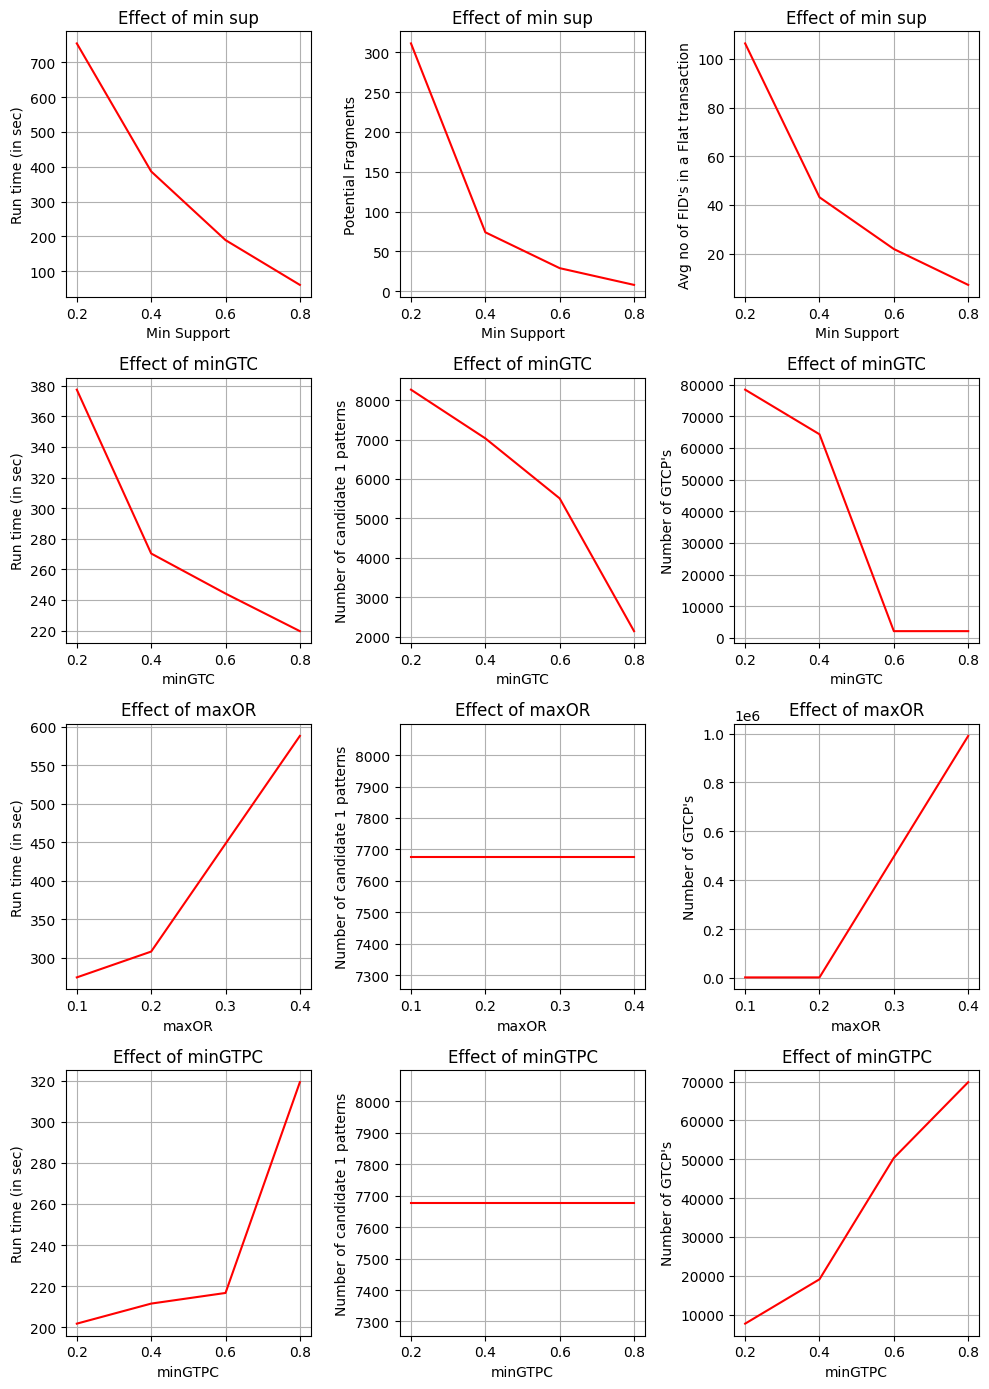

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 3, figsize=(10, 14))

x=[minsups,minsups,minsups];y=[runtimes_1,potentialf_1,avg_gi_1];
titles=["Effect of min sup","Effect of minGTC","Effect of maxOR","Effect of minGTPC"]
ylabels=["Run time (in sec)","Potential Fragments","Avg no of FID's in a Flat transaction"]
for i in range(3):
  axs[0,i].plot(x[i], y[i], 'r')
  axs[0,i].set_xlabel("Min Support")
  axs[0,i].set_ylabel(ylabels[i])
  axs[0,i].set_title(titles[0])
  axs[0,i].grid(True)

x=[minGTCs,minGTCs,minGTCs];y=[runtimes_2,candidate_2,ngtcp_2];
ylabels=["Run time (in sec)","Number of candidate 1 patterns","Number of GTCP's"]
for i in range(3):
  axs[1,i].plot(x[i], y[i], 'r')
  axs[1,i].set_xlabel("minGTC")
  axs[1,i].set_ylabel(ylabels[i])
  axs[1,i].set_title(titles[1])
  axs[1,i].grid(True)

x=[maxORs,maxORs,maxORs];y=[runtimes_4,candidate_4,ngtcp_4];
ylabels=["Run time (in sec)","Number of candidate 1 patterns","Number of GTCP's"]
for i in range(3):
  axs[2,i].plot(x[i], y[i], 'r')
  axs[2,i].set_xlabel("maxOR")
  axs[2,i].set_ylabel(ylabels[i])
  axs[2,i].set_title(titles[2])
  axs[2,i].grid(True)


x=[minGTPCs,minGTPCs,minGTPCs];y=[runtimes_3,candidate_3,ngtcp_3];
ylabels=["Run time (in sec)","Number of candidate 1 patterns","Number of GTCP's"]
for i in range(3):
  axs[3,i].plot(x[i], y[i], 'r')
  axs[3,i].set_xlabel("minGTPC")
  axs[3,i].set_ylabel(ylabels[i])
  axs[3,i].set_title(titles[3])
  axs[3,i].grid(True)

plt.tight_layout()

# Show the plot
plt.show()
